# Importing packages

In [1]:
import os

import numpy as np
import pandas as pd

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
plt.style.use('fivethirtyeight')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import Compose, ToTensor, Resize, RandomResizedCrop, Normalize
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights

from data_preparation.arrange_train_images import arrange_images
from data_preparation.create_train_csv import create_csv
from data_preparation.create_features import create_train_data

from models.v1 import CatDogModel

# Data/Image exploration

Set the value of arange_folder to True in the cell below if you want to arrange the content of the train folder into cat and dog folders.

In [2]:
arange_folder = True

if arange_folder:
    arrange_images()
else:
    pass

0it [00:00, ?it/s]


Let's create a csv file for train data by setting get_csv to True. If get_csv is False we will skip this step.

In [3]:
get_csv = True

if get_csv:
    create_csv()
else:
    pass

Let's check the train.csv file.

In [4]:
train_df = pd.read_csv('train.csv')
train_df.head()

,file,pet
0,0.jpg,cat
1,1.jpg,cat
2,10.jpg,cat
3,100.jpg,cat
4,1000.jpg,cat


Creating a target column and showing class distribution

In [5]:
map_dict = {"cat": 1, "dog": 0}

train_df['target'] = train_df['pet'].map(map_dict)

train_df['pet'].value_counts(normalize=True)

pet
cat    0.5
dog    0.5
Name: proportion, dtype: float64

The two classes are equally distributed in the train data. So we can use accuracy as a metric for gauging performance of future models. Let's also create fold column which will indicate to which fold a file in a row belongs to. Moreover we need to sustain the same proportion between the classes in each fold.

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    train_df.loc[val_idx, 'fold'] = int(fold + 1)

train_df.head()

,file,pet,target,fold
0,0.jpg,cat,1,1.0
1,1.jpg,cat,1,5.0
2,10.jpg,cat,1,4.0
3,100.jpg,cat,1,2.0
4,1000.jpg,cat,1,5.0


Let's show some images from the train folder.

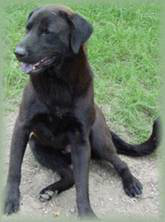

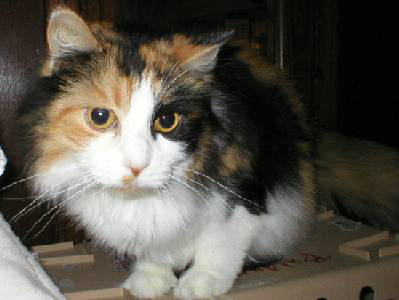

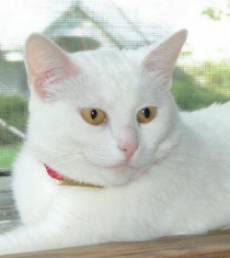

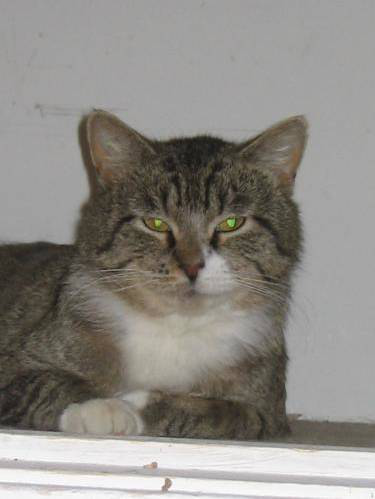

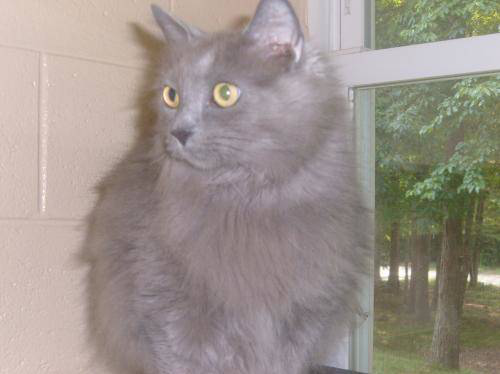

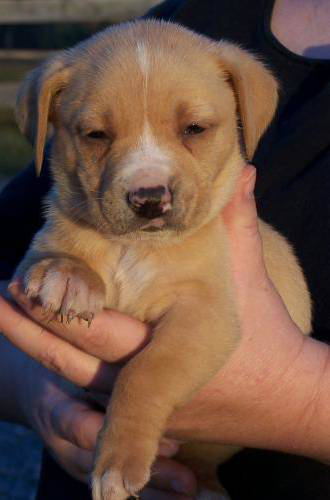

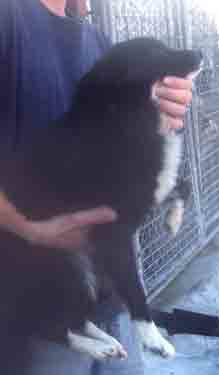

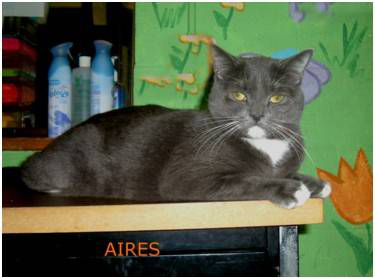

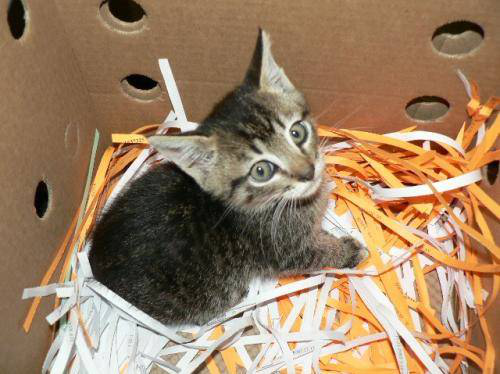

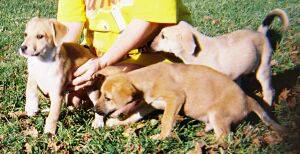

In [7]:
show_df = train_df.sample(10, random_state=13)

for row in show_df.itertuples():
    # temp_class = row.pet
    # temp_file = row.file
    im = Image.open(f"train/{row.pet}/{row.file}")
    display(im)

# Model building

Let's use resnet18 to as feature extractor. So first of all we need to load the pretrained resnet18 model.

In [8]:
resnet_18 = resnet18(weights=ResNet18_Weights)

for name, _ in resnet_18.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

c:\Users\vchar\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freezing the parameters of resnet18 to avoid their update

In [9]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_model(model=resnet_18)

Setting the fc layer of resnet18 to identity which will allow us to get features from the model to use in other models.

In [10]:
resnet_18.fc = nn.Identity()

Obtaining features from resnet18 for train data

In [11]:
create_train_features = False

if create_train_features:
    create_train_data(model=resnet_18, data_df=train_df)
else:
    pass

Creating a custom dataset class to load the features derived from the resnet18

In [17]:
class Resnet18Dataset(Dataset):

    def __init__(self, df, is_test=False, save_filename=False):

        self.is_test = is_test

        self.df = df

        self.save_filename = save_filename

    def __getitem__(self, index):

        feats_list = [col for col in self.df.columns if col not in ['target', 'fold']]

        self.X = torch.as_tensor(self.df.iloc[index][feats_list].values).float()

        if self.save_filename:
            filename = train_df.iloc[index]['file']

        if self.is_test:

            if self.save_filename:
                return (self.X, filename)
            else:
                return self.X

        else:

            self.y = self.df.iloc[index]['target']
            self.y = torch.as_tensor(self.y).float()

            if self.save_filename:
                return (self.X, self.y, filename)
            else:
                return (self.X, self.y)

    def __len__(self):
        return len(self.df)

In [18]:
def get_accuracy(model_class, data_loader):

    temp_preds = []

    temp_y = []

    temp_images = []

    for X, y, images in data_loader:

        temp_preds_batch = model_class.predict(X)
        temp_preds.append(temp_preds_batch)

        temp_y.append(y.cpu().numpy())

        temp_images.append(images)

    temp_preds = np.concatenate(temp_preds)
    temp_preds = list(map(lambda x: 1 if x>0.5 else 0, temp_preds))

    temp_y = np.concatenate(temp_y)

    temp_images = np.concatenate(temp_images)

    accuracy_value = accuracy_score(temp_y, temp_preds)

    return accuracy_value, temp_y, temp_preds, temp_images

Applying cross validation

Fold1 model building started!!!


Epoch 9: 100%|██████████| 10/10 [03:51<00:00, 23.15s/it]


Fold 1: Train accuracy = 0.967, Validation accuracy = 0.963


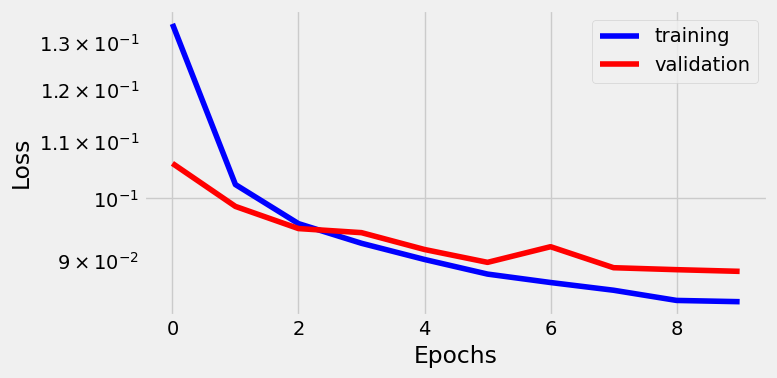

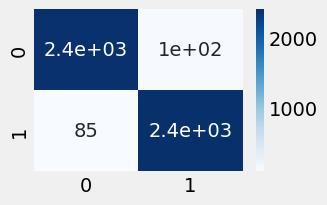

Fold2 model building started!!!


Epoch 9: 100%|██████████| 10/10 [03:52<00:00, 23.20s/it]


Fold 2: Train accuracy = 0.966, Validation accuracy = 0.966


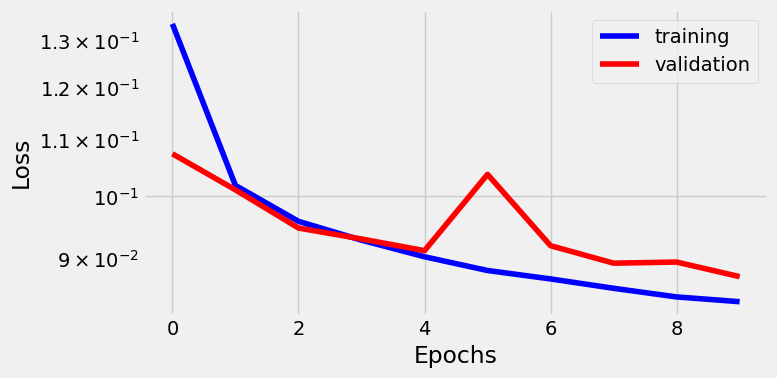

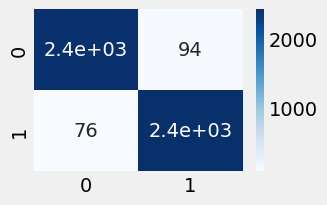

Fold3 model building started!!!


Epoch 9: 100%|██████████| 10/10 [03:55<00:00, 23.58s/it]


Fold 3: Train accuracy = 0.965, Validation accuracy = 0.969


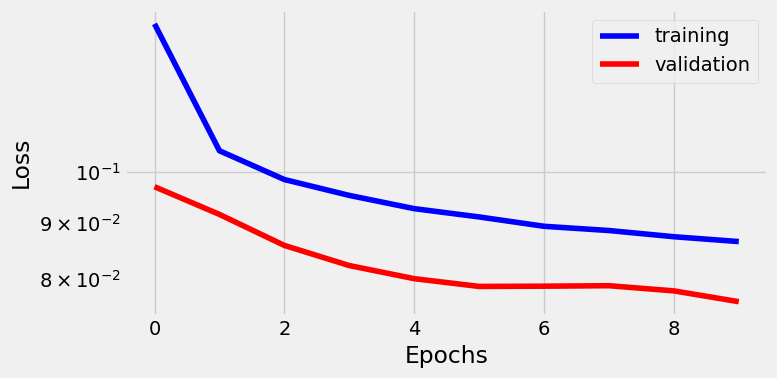

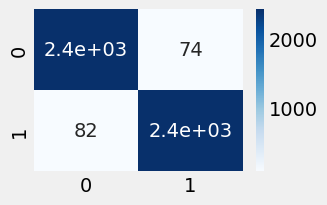

Fold4 model building started!!!


Epoch 9: 100%|██████████| 10/10 [03:53<00:00, 23.30s/it]


Fold 4: Train accuracy = 0.967, Validation accuracy = 0.957


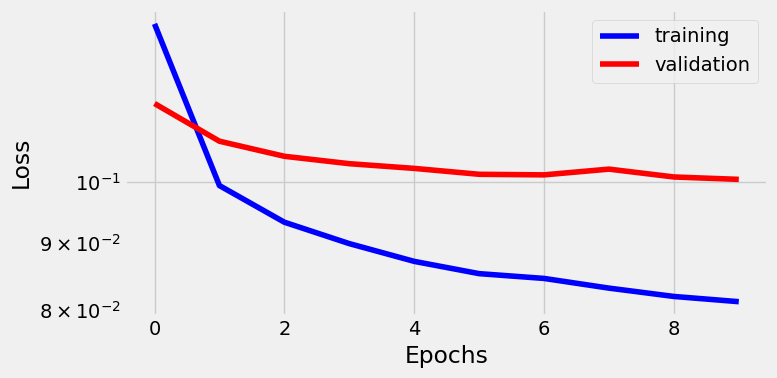

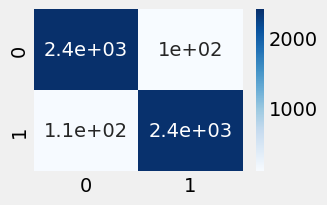

Fold5 model building started!!!


Epoch 9: 100%|██████████| 10/10 [03:51<00:00, 23.15s/it]


Fold 5: Train accuracy = 0.967, Validation accuracy = 0.960


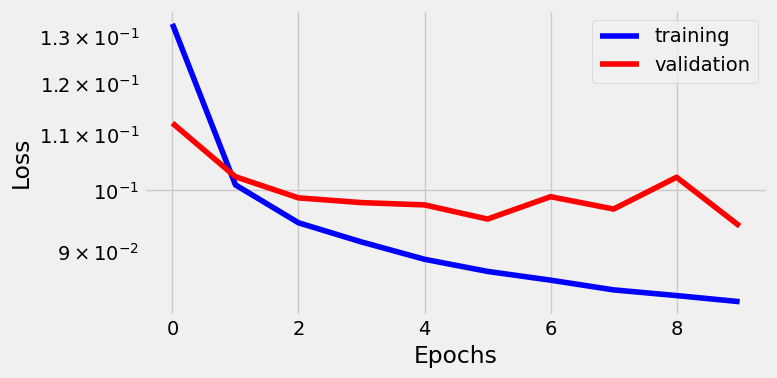

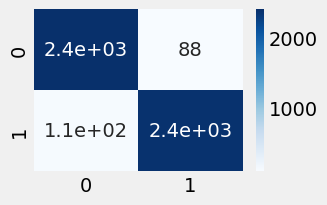

Average Val Accuracy = 0.963, Std. Val Accuracy = 0.004


In [15]:
train_feats_df = pd.read_csv("train_resnet18.csv")

# test_df_all = pd.read_csv("test_resnet18_all.csv")

# test_preds = []

val_accuracy = []

for fold in range(1, 6):

    print(f"Fold{fold} model building started!!!")

    # train_composer = Compose(
    #     [
    #         ToTensor(),
    #         CenterCrop(224) 
    #     ]
    # )

    train_data = Resnet18Dataset(
        df=train_feats_df[train_feats_df['fold']!=fold],
        is_test=False
    )

    train_loader = DataLoader(
        dataset=train_data,
        shuffle=True,
        batch_size=16
    )

    # val_composer = Compose(
    #     [
    #         ToTensor(),
    #         CenterCrop(224) 
    #     ]
    # )

    val_data = Resnet18Dataset(
        df=train_feats_df[train_feats_df['fold']==fold], 
        is_test=False
    )

    val_loader = DataLoader(
        dataset=val_data,
        shuffle=False,
        batch_size=16
    )

    val_data2 = Resnet18Dataset(
        df=train_feats_df[train_feats_df['fold']==fold], 
        is_test=False,
        show_filename=True
    )

    val_loader2 = DataLoader(
        dataset=val_data2,
        shuffle=False,
        batch_size=16
    )

    # test_composer = Compose(
    #     [
    #         ToTensor(),
    #         CenterCrop(224) 
    #     ]
    # )

    # test_data = Resnet18Dataset(
    #     df=test_df_all,  
    #     is_test=True
    # )

    # test_loader = DataLoader(
    #     dataset=test_data,
    #     shuffle=False,
    #     batch_size=16
    # )

    lr = 0.01

    torch.manual_seed(42)

    model = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())#.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr)

    loss_fn = nn.BCELoss(reduction='mean')

    n_epochs = 10

    cm = CatDogModel(model, loss_fn, optimizer)
    cm.set_loaders(train_loader, val_loader)
    # cm.set_tensorboard('cm_v1')
    cm.train(n_epochs)
    cm.plot_losses()
    cm.save_checkpoint(f'cm_v1_fold{fold}.pth')

    # temp_y_test_hat = combine_predictions(model_class=cm, data_loader=test_loader)
    # test_preds.append(temp_y_test_hat)

    temp_train_accuracy, _, _ = get_accuracy(model_class=cm, data_loader=train_loader)
    temp_val_accuracy, temp_val_y, temp_val_y_hat, temp_images = get_accuracy(model_class=cm, data_loader=val_loader2)
    val_accuracy.append(temp_val_accuracy)

    print(f"Fold {fold}: Train accuracy = {temp_train_accuracy:.3f}, Validation accuracy = {temp_val_accuracy:.3f}")

    fig = plt.figure(figsize=(3, 2))
    temp_cm = confusion_matrix(temp_val_y, temp_val_y_hat)
    sns.heatmap(temp_cm, cmap='Blues', annot=True)
    plt.show()

print(f"Average Val Accuracy = {np.mean(val_accuracy):.3f}, Std. Val Accuracy = {np.std(val_accuracy):.3f}")
